## Standardize headings

In [39]:
import re
from difflib import SequenceMatcher
import copy
import json


import json

def load_and_validate_json(file_path):
    """
    Load a JSON file and validate that it contains the expected structure
    with a 'children' field at the root level.

    Parameters:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The loaded JSON data.

    Raises:
        ValueError: If the JSON does not have the expected structure.
    """
    # Load JSON file
    with open(file_path, 'r') as f:
        json_data = json.load(f)
        print(f"JSON file '{file_path}' loaded successfully")

    # Validate JSON structure
    if not isinstance(json_data, dict):
        raise ValueError(f"The JSON file '{file_path}' must be a dictionary at the root level.")
    
    if 'children' not in json_data:
        raise ValueError(f"The JSON file '{file_path}' must contain a 'children' field at the root level.")
    
    return json_data

# Example usage:
# gt_json = load_and_validate_json('ground_truth.json')
# pred_json = load_and_validate_json('prediction.json')




def normalize_text(text):
    """Normalize text for comparison by removing special characters and standardizing spacing."""
    # Convert to lowercase
    text = text.lower()
    # Replace special characters with spaces
    text = re.sub(r'[.,(){}[\]\'\"#]', ' ', text)
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    # Strip leading/trailing whitespace
    return text.strip()

def calculate_similarity(text1, text2):
    """Calculate similarity ratio between two texts after normalization."""
    norm_text1 = normalize_text(text1)
    norm_text2 = normalize_text(text2)
    return SequenceMatcher(None, norm_text1, norm_text2).ratio()

def find_matching_headings(pred_json, gt_json, similarity_threshold=0.75):
    """Find matching headings between predicted and ground truth JSONs."""
    HEADING_TYPES = ['document', 'section', 'subsection', 'subsubsection', 'paragraph', 'subparagraph']
    matches = []
    changes = []
    
    def collect_headings(node, headings):
        if isinstance(node, dict) and node.get('type') in HEADING_TYPES:
            headings.append(node)
        if isinstance(node, dict) and 'children' in node:
            for child in node['children']:
                collect_headings(child, headings)
    
    pred_headings = []
    gt_headings = []
    collect_headings(pred_json, pred_headings)
    collect_headings(gt_json, gt_headings)
    
    # Find matches without type constraint
    for pred_heading in pred_headings:
        best_match = None
        best_similarity = similarity_threshold
        
        for gt_heading in gt_headings:
            similarity = calculate_similarity(pred_heading['name'], gt_heading['name'])
            if similarity > best_similarity:
                best_similarity = similarity
                best_match = gt_heading
        
        if best_match:
            matches.append((pred_heading, best_match))
            if pred_heading['name'] != best_match['name']:
                changes.append({
                    'original': pred_heading['name'],
                    'replaced_with': best_match['name'],
                    'similarity': best_similarity,
                    'original_type': pred_heading['type'],
                    'matched_type': best_match['type']
                })
    
    return matches, changes

def update_json_headings(json_data, matches):
    """Update the predicted JSON with matching heading names from ground truth."""
    updated_json = copy.deepcopy(json_data)
    
    def update_node(node):
        for match_pred, match_gt in matches:
            if isinstance(node, dict) and node.get('id') == match_pred['id']:
                node['name'] = match_gt['name']
        
        if isinstance(node, dict) and 'children' in node:
            for child in node['children']:
                update_node(child)
    
    update_node(updated_json)
    return updated_json

def normalize_headings(pred_json, gt_json):
    """Main function to normalize headings in predicted JSON based on ground truth."""
    matches, changes = find_matching_headings(pred_json, gt_json)
    updated_json = update_json_headings(pred_json, matches)
    
    return updated_json, changes

In [4]:
gt_file = 'gt_json.json'
pred_file = 'pred_json.json'

gt_json = load_and_validate_json(gt_file)
pred_json = load_and_validate_json(pred_file)


# Assuming pred_json and gt_json are your input JSONs
updated_json, changes = normalize_headings(pred_json, gt_json)

# Save the updated JSON to a new file
updated_json_file = 'updated_pred_json.json'
with open(updated_json_file, 'w') as f:
    json.dump(updated_json, f, indent=4)
    print(f"Updated JSON saved to '{updated_json_file}'")   



# Print report of changes
print("Heading Normalization Report:")
print("-" * 50)
for change in changes:
    print(f"Original: {change['original']} ({change['original_type']})")
    print(f"Replaced with: {change['replaced_with']} ({change['matched_type']})")
    print(f"Similarity score: {change['similarity']:.2f}")
    print("-" * 50)

FileNotFoundError: [Errno 2] No such file or directory: 'gt_json.json'

## Text Block Extractor

In [40]:
def extract_text(data, current_heading=None, result=None):
    if result is None:
        result = {}
        
    # Check if the current node has children and iterate through them
    if "children" in data:
        for child in data["children"]:
            # If the child is a heading (section, subsection, subsubsection, or paragraph)
            if child["type"] in ["document", "section", "subsection", "subsubsection", "paragraph", "subparagraph", "itemize", "enumerate"]:
                # Update the current heading name
                new_heading = child["name"]
                extract_text(child, new_heading, result)
                
            # If the child is of type "text," concatenate it to the current heading's text
            elif child["type"] == "text" and current_heading is not None:
                if current_heading in result:
                    result[current_heading] += child["name"]
                else:
                    result[current_heading] = child["name"]
                    
            # Recursively process the remaining children
            else:
                extract_text(child, current_heading, result)
    
    return result

In [41]:
test = load_and_validate_json('test.json')
# Get the list of dictionaries with headings and concatenated text
output = extract_text(test)
print(output)


JSON file 'test.json' loaded successfully
{'Price Range of Our Common Stock and Preferred Stock': '\nOur common sto', 'Dividends': '\nWe have not de', 'Shareholder Information': '\nOur shareholde', 'Overview': '\nThe following ', 'Financial Highlights': '\n2019 saw an in\\%...\n\nOur profit', 'Executive Officers': '\nThe company’s ', 'Governance Practices': '\nOur governance', 'itemize': ' Ensure compliance with all relevant regulations.\n     Monitor industry trends for emerging risks.\n     Engage with stakeholders to gather insights on potential threats.\n', 'Governance ': '\nwe do imp thin'}


In [1]:

dict1 =   {
    "Price Range of Our Common Stock and Preferred Stock": "\nOur common sto",
    "Dividends": "\nWe have not de",
    "Shareholder Information": "\nOur shareholde",
    "Overview": "\nThe following ",
    "Financial Highlights": "\n2019 saw an in\\%...\n\nOur profit",
    "Executive Officers": "\nThe company’s ",
    "Governance Practices": "\nOur governance",
    "itemize": " Ensure compliance with all relevant regulations.\n Monitor industry trends for emerging risks.\n Engage with stakeholders to gather insights on potential threats.",
    "Governance": "\nwe do imp thin"
  }
dict2 =  {
    "Price Range of Our Common Stock and Preferred Stock": "\nOur common stock and preferred shares maintained a steady range throughout the fiscal period.",
    "Dividends": "\nNo dividends have been declared for this year, but the policy remains under consideration.",
    "Shareholder Information": "\nOur shareholder base and engagement efforts have expanded, reflecting positive growth.",
    "Overview and Summary": "\nThe following overview summarizes key annual achievements and financial performance.",
    "Financial Summary": "\nIn 2019, we observed an increase in profits by 10%... \n\nOur financial standing strengthened.",
    "Executive Officers": "\nOur leadership team comprises seasoned professionals with diverse industry backgrounds.",
    "Governance Practices": "\nOur governance practices are aligned with industry standards and regulatory requirements.",
    "itemize": "Ensure adherence to all applicable regulations.\n Monitor industry trends to preemptively address risks.\n Engage with stakeholders to stay informed on potential industry shifts.",
    "Governance": "\nEthical standards and governance principles are a top priority within our operations.",
    "Corporate Social Responsibility": "\nThe company has increased efforts in community engagement and environmental responsibility.",
    "Regulatory Compliance": "Ensure compliance with all updated regulatory requirements.\n Stay informed on industry developments and trends.\n Engage stakeholders to proactively identify potential threats."
  }



In [2]:
matching_values = []

common_keys = dict1.keys() & dict2.keys()
for key in common_keys:
    matching_values.append((dict1[key], dict2[key]))

for key in (dict1.keys() - dict2.keys()):
    matching_values.append((dict1[key], ""))

for key in (dict2.keys() - dict1.keys()):
    matching_values.append(("", dict2[key]))

print(matching_values)

[(' Ensure compliance with all relevant regulations.\n Monitor industry trends for emerging risks.\n Engage with stakeholders to gather insights on potential threats.', 'Ensure adherence to all applicable regulations.\n Monitor industry trends to preemptively address risks.\n Engage with stakeholders to stay informed on potential industry shifts.'), ('\nOur shareholde', '\nOur shareholder base and engagement efforts have expanded, reflecting positive growth.'), ('\nThe company’s ', '\nOur leadership team comprises seasoned professionals with diverse industry backgrounds.'), ('\nOur governance', '\nOur governance practices are aligned with industry standards and regulatory requirements.'), ('\nwe do imp thin', '\nEthical standards and governance principles are a top priority within our operations.'), ('\nWe have not de', '\nNo dividends have been declared for this year, but the policy remains under consideration.'), ('\nOur common sto', '\nOur common stock and preferred shares maintaine

In [3]:
from rouge_score import rouge_scorer
import numpy as np

# Initialize ROUGE scorer for LCS (Longest Common Subsequence)
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)

# Lists to store individual micro scores
micro_scores = []

# Calculate micro ROUGE-L score (individual score for each pair)
for ref, hyp in matching_values:
    scores = scorer.score(ref, hyp)
    rouge_l_fmeasure = scores['rougeL'].fmeasure
    micro_scores.append(rouge_l_fmeasure)

# Micro-average ROUGE-L score (average of individual scores)
micro_rouge_l = round(np.mean(micro_scores), 2)

# Calculate macro ROUGE-L by concatenating all reference and hypothesis texts
all_ref = " ".join([ref for ref, _ in matching_values])
all_hyp = " ".join([hyp for _, hyp in matching_values])
macro_scores = scorer.score(all_ref, all_hyp)
macro_rouge_l = round(macro_scores['rougeL'].fmeasure, 2)

# Output the macro and micro ROUGE-L scores
print("Micro ROUGE-L Scores for each pair:", [round(score, 2) for score in micro_scores])
print(f"Macro ROUGE-L Score: {macro_rouge_l}")
print(f"Micro-average ROUGE-L Score: {micro_rouge_l}")


Micro ROUGE-L Scores for each pair: [0.59, 0.15, 0.0, 0.31, 0.0, 0.11, 0.24, 0, 0, 0, 0, 0, 0]
Macro ROUGE-L Score: 0.24
Micro-average ROUGE-L Score: 0.11


In [4]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Initialize smoothing function
smoothie = SmoothingFunction().method4

# Calculate BLEU score for each pair
bleu_scores = []
for ref, hyp in matching_values:
    # Tokenize sentences
    reference = [ref.split()]  # reference must be a list of lists for sentence_bleu
    hypothesis = hyp.split()
    # Compute BLEU score
    bleu_score = sentence_bleu(reference, hypothesis, smoothing_function=smoothie)
    bleu_scores.append(bleu_score)

# Calculate Averaged BLEU (average of individual BLEU scores)
average_bleu = np.mean(bleu_scores)


print(f"BLEU Scores for each pair: {bleu_scores}")
print(f"Average BLEU Score: {average_bleu:.4f}")


BLEU Scores for each pair: [0.2927057121559396, 0.021598265052211615, 0, 0.05190794196013298, 0, 0.01758542189440898, 0.041263216881455095, 0, 0, 0, 0, 0, 0]
Average BLEU Score: 0.0327


## main

In [10]:
from latex_to_json import tex_file_to_json
tex_file_to_json("/home/azureuser/cloudfiles/code/Users/omar.bayoumi/zerox/py_zerox/test.md")

JSON output saved to /home/azureuser/cloudfiles/code/Users/omar.bayoumi/zerox/py_zerox/test.json


In [2]:
from DAR import evaluate_hierarchy
try:
    metrics = evaluate_hierarchy('test.json', 'test.json', print_details=True)
except Exception as e:
    print(f"Error during evaluation: {e}")

Ground truth JSON loaded successfully
Predicted JSON loaded successfully

=== EVALUATION SCORES ===


PARENT_CHILD SCORES:
--------------------
precision: 1.000
recall: 1.000
f1: 1.000
accuracy: 1.000

SIBLING SCORES:
---------------
precision: 1.000
recall: 1.000
f1: 1.000
accuracy: 1.000

COMBINED SCORES:
----------------
precision: 1.000
recall: 1.000
f1: 1.000
accuracy: 1.000

=== DETAILED RELATION ANALYSIS ===


PARENT_CHILD RELATIONS:

Ground Truth Relations:
--------------------
  Compliance and Risk Monitoring (Type: paragraph) → itemize (Type: itemize)
  Dividends (Type: subsubsection) → 
We have not de (Type: text)
  Dividends (Type: subsubsection) → Shareholder Information (Type: paragraph)
  Executive Officers (Type: subsection) → 
The company’s  (Type: text)
  Executive Officers (Type: subsection) → Governance  (Type: subsubsection)
  Executive Officers (Type: subsection) → Governance Practices (Type: subsubsection)
  Financial Highlights (Type: subsubsection) → 
2019 saw 

- Standardize parent nodes [done]
- Wrap text as node with no children (not floating text) [done]
- apply on real text from SEC and iterate with json2latex 
    - doc to children types [done] 
    - nodes -> text [done]
    - itemize -> text [done]

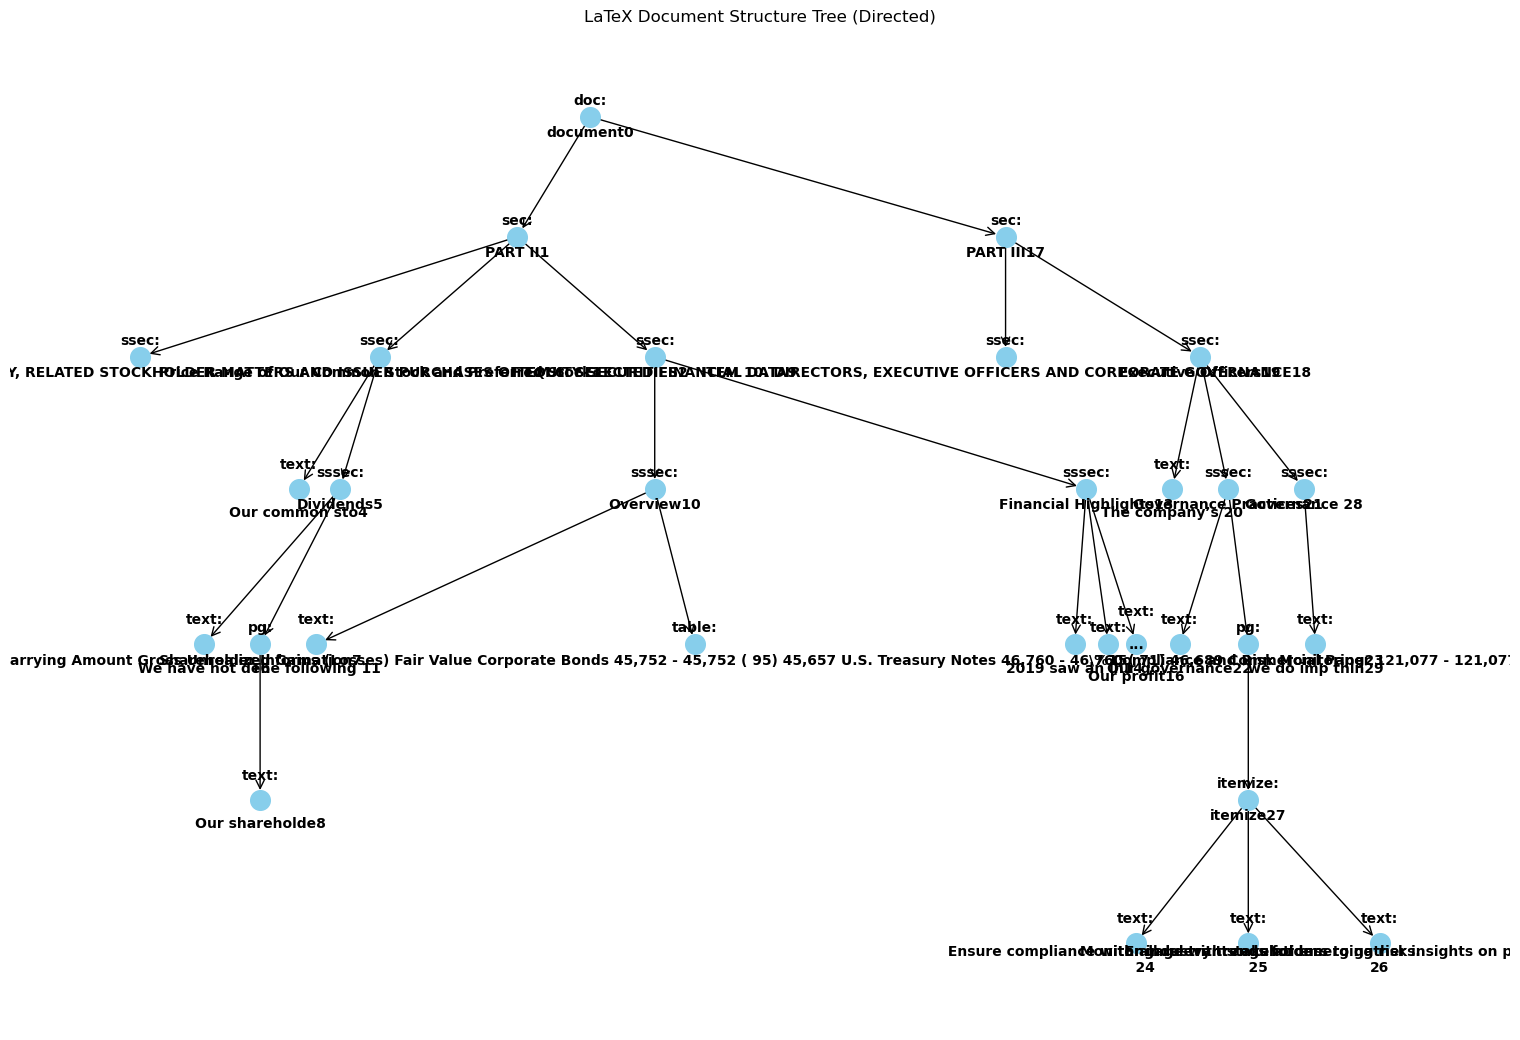

In [2]:
import json
from graph_plotter import draw_dict
def read_json_file_as_dict(file_path):
    with open(file_path, 'r') as file:
        data_dict = json.load(file)
    return data_dict

# Example usage
file_path = 'test.json'
data_dict = read_json_file_as_dict(file_path)


draw_dict(data_dict)
